<h3>Dataset Setup</h3>

In [1]:
!pip install h5py

In [2]:
!pip install numpy

In [3]:
import os
import h5py
import time
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math

In [4]:
filename = r"D:\N_CMAPS\Dataset\data_set\N-CMAPSS_DS02-006.h5"

In [5]:
# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
   
X_train_vals = np.concatenate((W_dev, X_s_dev, X_v_dev, T_dev, A_dev), axis=1)
y_train_vals = Y_dev.copy()
X_test_vals = np.concatenate((W_test, X_s_test, X_v_test, T_test, A_test), axis=1)
y_test_vals = Y_test.copy()

X_names = np.concatenate((W_var, X_s_var, X_v_var, T_var, A_var))

X = DataFrame(data=X_train_vals, columns=X_names)
y = DataFrame(data=y_train_vals, columns=["RUL"])
X_test = DataFrame(data=X_test_vals, columns=X_names)
y_test = DataFrame(data=y_test_vals, columns=["RUL"])

del X_train_vals, y_train_vals, X_test_vals, y_test_vals, W_dev, X_s_dev, X_v_dev, T_dev, Y_dev, A_dev, W_test, X_s_test, X_v_test, T_test, Y_test, A_test, W_var, X_s_var, X_v_var, T_var, A_var
del X_test , y_test
split_ratio = 0.7
split_index = int(len(X) * split_ratio)

# Split the data
X_train = X[:split_index]
y_train = y[:split_index]
X_test = X[split_index:]
y_test = y[split_index:]

print("X Train Split shape:", X_train.shape)
print("Y Train Split shape:", y_train.shape)
print("X Test Split shape:", X_test.shape)
print("Y Test Split shape:", y_test.shape)



X Train Split shape: (3684412, 46)
Y Train Split shape: (3684412, 1)
X Test Split shape: (1579035, 46)
Y Test Split shape: (1579035, 1)


<h3>Starting Machine Learning</h3>

In [6]:
from pandas import DataFrame
from pandas import concat
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

<h2>Preprocessing</h2>

In [7]:
from sklearn.preprocessing import MinMaxScaler
timesteps = 10

scaler = MinMaxScaler()

scaled_X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(scaled_X_train, columns=X_train.columns)

scaled_X_test = scaler.transform(X_test)
X_test = pd.DataFrame(scaled_X_test, columns=X_test.columns)

In [8]:
from sklearn.decomposition import PCA

using_pca = True
pca_variance = 0.9
pca_components = 5

if using_pca:
    pca = PCA(n_components = pca_components)
    pca.fit(X_train)
    print(pca.n_components_)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
else:
    important_features = ['HPT_eff_mod', 'LPT_eff_mod', 'LPT_flow_mod', 'cycle', 'hs']
    X_train = X_train[important_features]
    X_test = X_test[important_features]


5


<BarContainer object of 5 artists>

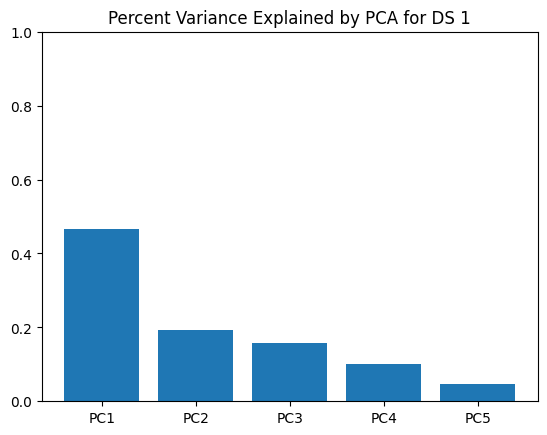

In [9]:
ratio = pca.explained_variance_ratio_
plt.ylim(0,1)
plt.title("Percent Variance Explained by PCA for DS 1")
plt.bar(["PC1", "PC2", "PC3", "PC4", "PC5"], ratio)
#plt.savefig('../figures/PCA_ex.pdf')

In [10]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [11]:
X_train = series_to_supervised(X_train, timesteps-1, 1)
X_test = series_to_supervised(X_test, timesteps-1, 1)

y_train = y_train[:-timesteps+1]
y_test = y_test[:-timesteps+1]

print(X_train.shape, X_test.shape)

(3684403, 50) (1579026, 50)


In [12]:
def reshape_df(df):
    numpy_df = df.to_numpy()
    reshaped = np.reshape(numpy_df, (df.shape[0], timesteps, int(X_train.shape[1]/timesteps)))
    return reshaped


X_train_arr = reshape_df(X_train)

X_test_arr = reshape_df(X_test)

y_train_arr = y_train.to_numpy().reshape(X_train_arr.shape[0], 1, 1)

y_test_arr = y_test.to_numpy().reshape(X_test_arr.shape[0], 1, 1)

print(X_train_arr.shape, y_train_arr.shape)
print(X_test_arr.shape, y_test_arr.shape)

(3684403, 10, 5) (3684403, 1, 1)
(1579026, 10, 5) (1579026, 1, 1)


In [13]:
del X_train, X_test

<h2>Model Training</h2>

In [14]:
# import tensorflow as tf
# from tensorflow.keras.layers import Layer, Activation
# import numpy as np

# # Custom Attention Layer
# class DotProductAttention(Layer):
#     def __init__(self, **kwargs):
#         super(DotProductAttention, self).__init__(**kwargs)

#     def build(self, input_shape):
#         self.w_q = self.add_weight(name="w_q", shape=(input_shape[-1], 128), trainable=True)
#         self.w_k = self.add_weight(name="w_k", shape=(input_shape[-1], 128), trainable=True)
#         super(DotProductAttention, self).build(input_shape)

#     def call(self, inputs):
#         q = tf.matmul(inputs, self.w_q)
#         k = tf.matmul(inputs, self.w_k)
#         v = inputs
#         attn_scores = tf.matmul(q, k, transpose_b=True)

#         # Apply L2 regularization to the attention scores
#         attn_scores = attn_scores + 0.01 * tf.norm(attn_scores, ord='euclidean')

#         attn_scores = Activation('softmax')(attn_scores)
#         output = tf.matmul(attn_scores, v)
#         return output

# # Define the input shape for your data
# timesteps = 10
# n_features = 16  # This should match your data's features

# # Encoder
# encoder_inputs = tf.keras.layers.Input(shape=(timesteps, n_features))
# encoder_lstm = tf.keras.layers.LSTM(16, activation='relu', recurrent_dropout=0.55, return_sequences=True)(encoder_inputs)
# encoder_attention = DotProductAttention()(encoder_lstm)
# encoder_output = tf.keras.layers.Lambda(lambda x: x[:, -1, :])(encoder_attention)

# # Calculate z_std (standard deviation) as a trainable parameter
# z_std = tf.keras.layers.Dense(16, activation='softplus', kernel_initializer='zeros')(encoder_output)

# # Sample z from z_mean and z_std
# z = tf.keras.layers.Lambda(lambda x: x[0] + tf.exp(0.5 * x[1]) * tf.random.normal(shape=(tf.shape(x[0])[0], 16)))([encoder_output, z_std])

# # Decoder
# decoder_inputs = tf.keras.layers.Input(shape=(timesteps, n_features))
# decoder_lstm = tf.keras.layers.LSTM(16, activation='relu', return_sequences=True)(decoder_inputs, initial_state=[z, z])
# decoder_dropout = tf.keras.layers.Dropout(0.3)(decoder_lstm)
# decoder_output = tf.keras.layers.Dense(1)(decoder_dropout)

# # Combine encoder and decoder into a single model
# model = tf.keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_output)

# # Compile the model
# model.compile(optimizer='Adam', loss='mse', metrics=['mse'])

# # Print the model summary
# model.summary()


In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, Attention, Multiply
from tensorflow.keras.models import Model

n_features = X_train_arr.shape[2]

# Define input layer
input_layer = Input(shape=(timesteps, n_features))

# Define input layer
input_layer = Input(shape=(timesteps, n_features))

# First Bidirectional LSTM layer
bi_lstm_1 = Bidirectional(LSTM(64, activation='relu', recurrent_dropout=0.55, return_sequences=True))(input_layer)


# Attention layer
attention = Attention(use_scale=True)([bi_lstm_1, bi_lstm_1])

# Calculate the weighted sum using the Lambda layer
weighted_sum = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x[0] * x[1], axis=1))([attention, bi_lstm_1])

# Dropout layer
dropout = Dropout(0.3)(weighted_sum)

# Dense output layer
output_layer = Dense(1)(dropout)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='Adam', loss='mse', metrics=['mse'])

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 10, 5)]              0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 10, 128)              35840     ['input_2[0][0]']             
 al)                                                                                              
                                                                                                  
 attention (Attention)       (None, 10, 128)              1         ['bidirectional[0][0]',       
                                                                     'bidirectional[0][0]']       
                                                                                              

In [16]:
history = model.fit(X_train_arr, y_train_arr,epochs=1, verbose=1)

115138/115138 [==============================] - 1447s 12ms/step - loss: 16.2708 - mse: 16.2708


In [17]:
from sklearn.metrics import r2_score
yhat = model.predict(X_test_arr)

49345/49345 [==============================] - 237s 5ms/step


<h2>Test Performance</h2>

In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(y_true=y_test, y_pred=yhat)
print(sqrt(mse))

7.804039076674144


In [19]:
predictions = np.round(yhat)

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20,10))
plt.title("True Test RUL vs Predicted Test RUL DS 2")
plt.plot(np.arange(0, y_test.shape[0], 1), y_test['RUL'], color="black")
plt.plot(np.arange(0, y_test.shape[0], 1), predictions, alpha=0.35, color="red")
plt.legend(["True RUL", "Predicted RUL"])
plt.savefig('../figures/ds4_performance.pdf')

In [21]:
def nasa_score(true, predicted):
    score = 0
    i = 0
    
    for x in true:
        alpha = 0.1
        
        if predicted[i] < x:
            alpha = 1/13
        
        score += math.exp(alpha*abs(x - predicted[i])-1)
        i += 1
    
    return score / true.size

print(nasa_score(np.array(y_test['RUL']), yhat))

0.8351194825967843


<h2>Train Performance</h2>

In [22]:
y = model.predict(X_train_arr)
y_predictions = np.round(y)

115138/115138 [==============================] - 593s 5ms/step


FileNotFoundError: [Errno 2] No such file or directory: '../figures/overfit_ds2.pdf'

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

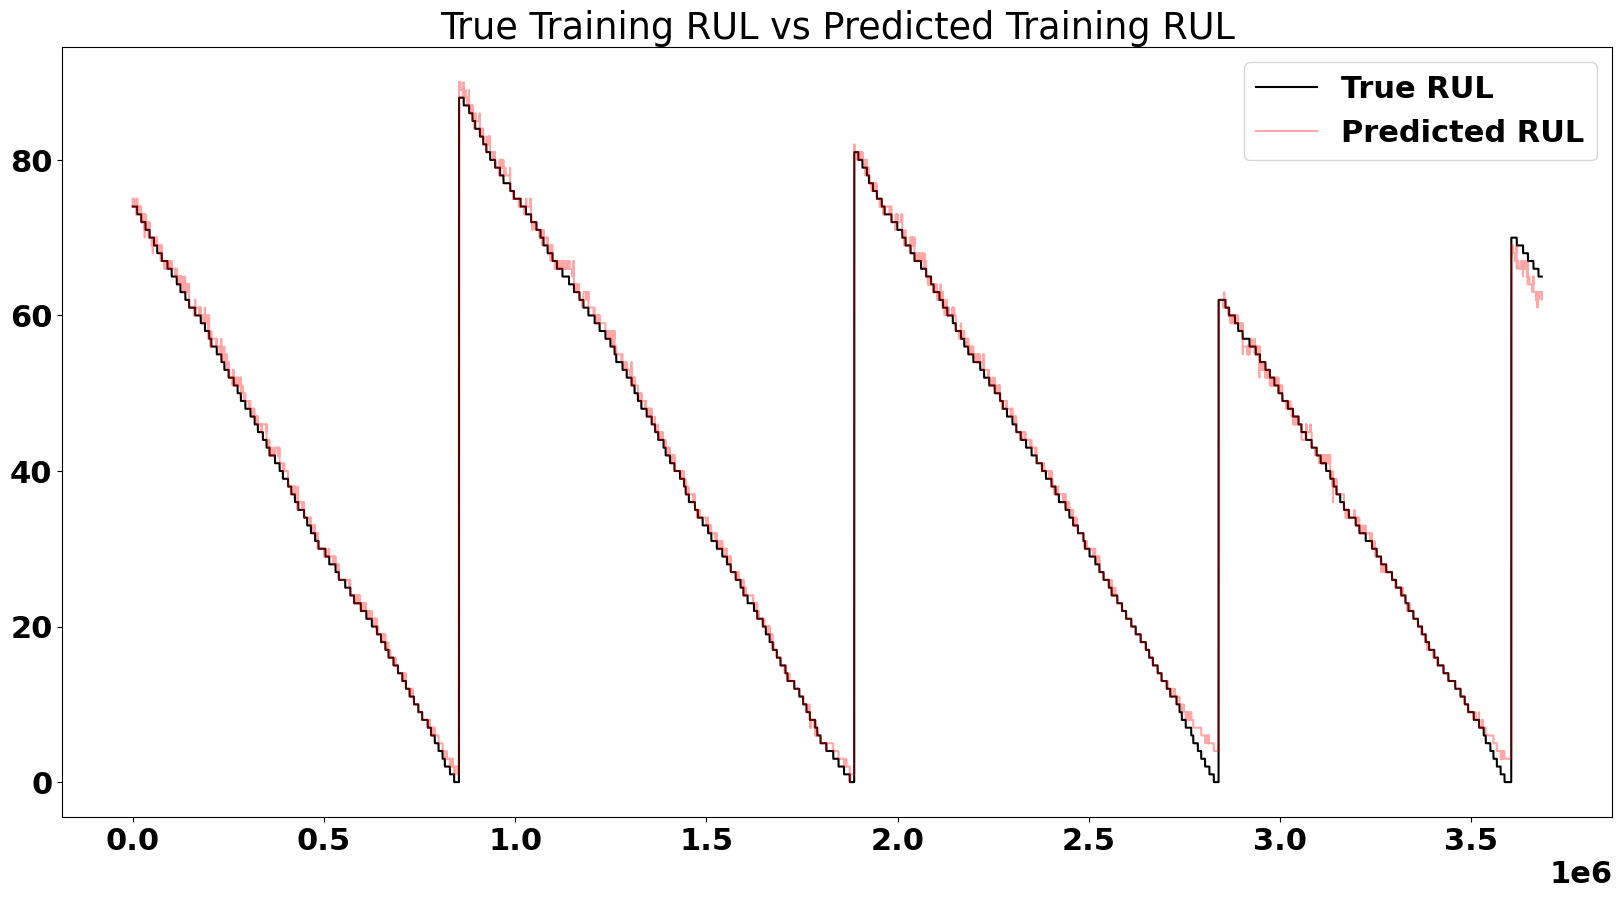

In [23]:
plt.figure(figsize=(20,10))
plt.title("True Training RUL vs Predicted Training RUL")
plt.plot(np.arange(0, y_train.shape[0], 1), y_train['RUL'], color='black')
lt.plot(np.arange(0, y_train.shape[0], 1), y_predictions, alpha=0.35, color='red')
plt.legend(["True RUL", "Predicted RUL"])
plt.savefig('../figures/overfit_ds2.pdf')

In [24]:
print(sqrt(mean_squared_error(y_true=y_train, y_pred=y)))
r2_score(y_true=y_train, y_pred=y)

0.9755576879101844


0.9982431893140216

<h3>Model Saving and Loading</h3>

In [ ]:
model.save('.\\lstm_models\lstm_ds02')